## **The code below is to correct for water level logger drift, check accuracy of logger deployment and add the deployment block information to the block table.**

It does not require any Python knowledge, but it does require Python and certain packages to be installed on your computer. Read the code comments embedded in each code block carefully (denoted by '#'), as some components require user input (initials, manual water level measurements, etc.).

---



**Connect to Shared Drive**

You will be prompted to click on a link that will show you an authorization code. copy the authorization code into the input box below. You also may be asked to allow Google Colab access to your Drive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
from datetime import date
import csv
import os

Specify path (location of file), endpath (where the result will be saved), and file name below.

In [112]:
path='/content/drive/My Drive/Water/preprocess_files/'
endpath='/content/drive/My Drive/Water/postprocess_files/'
file='AL-B_20201201_LT_baroC.csv'

df=pd.read_csv(path+file,index_col=[0])

For **Solinst brand loggers**, run the 1 code block below. Skip this if you're using a different brand logger.

In [ ]:
#Add extra DateTime field for interactive plot
df['DateTime']=pd.to_datetime(df['Date']+" "+df['Time'])

#Find start and end dates from logger file
start_date=df['Date'][0]
end_date=df['Date'][len(df['Date'])-1]
print('Need manual measurements collected on '+start_date+' and '+end_date)

Enter field water level measurements as variables below.

In [93]:
start_lev=0.2024
end_lev=0.258

Plot water level data. Will pop up in a new browser window if using a local runtime, otherwise use Excel for now.

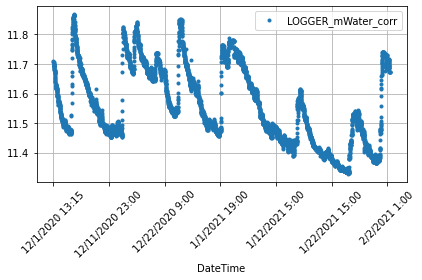

In [98]:
#df.plot(x='DateTime',y='LOGGER_mWater_corr',style='.',rot=45)
df.plot(y='LOGGER_mWater_corr',style='.',rot=45)
plt.grid()
plt.tight_layout()
plt.show()

**Below are some common corrections to remove noisy or rogue data points**

All require some manual entry (i.e. number of rows, date and time). Zoom in and pan through the interactive plot to find info for specific points or periods of data. You can run one or more separately.

In [ ]:
#To remove a specified number of records at the start of the file
#Enter the number of rows below as start_del
start_del=1
df=df.iloc[start_del:]

In [ ]:
#To remove a specified number of records at the end of the file
#Enter the number of rows below as end_del
end_del=1
df=df.iloc[:-end_del]

In [ ]:
#To interpolate values between two records (i.e. smooth over a point)
#Change the date and time to that of whatever point you want to smooth over
#Can do this multiple times for multiple points and the interpolate function will do all at once
point=(df.index.get_loc('08/28/2020 14:30:00'))
df['LOGGER_mWater_corr'][point]=np.nan
df['LOGGER_mWater_corr']=df['LOGGER_mWater_corr'].interpolate(axis=0)
print(df['LOGGER_mWater_corr'][point])

In [ ]:
#To interpolate values over multiple records (i.e. interpolate over multiple consecutive records)
#Change the date and time for the first (first_pt) and last (last_pt) of the interval
first_pt=df.index.get_loc('08/28/2020 14:30:00')
last_pt=df.index.get_loc('08/28/2020 15:30:00')+1
df['LOGGER_mWater_corr'][first_pt:last_pt]=np.nan
df['LOGGER_mWater_corr']=df['LOGGER_mWater_corr'].interpolate(axis=0)

**After removing and cleaning all noisy data, run the code below to correct water level values for sensor drift**

Your starting level (first record value) should match your starting manual measurement and your ending level (last record value) should match your end manual measurement.

In [113]:
df['LOGGER_mDTW_corr']=df['LOGGER_mWater_corr']
n=len(df['LOGGER_mWater_corr'])-1
LTCinit=df['LOGGER_mWater_corr'][0]
LTCend=df['LOGGER_mWater_corr'][n]
df['LOGGER_mDTW_corr']=start_lev-(df['LOGGER_mWater_corr']-LTCinit)
R1=df['LOGGER_mDTW_corr'][0]
R2=df['LOGGER_mDTW_corr'][n]
acc=(end_lev-R2)-(start_lev-R1)
K=acc/(n-1)

new_lc=[]
for index,val in enumerate(df['LOGGER_mDTW_corr'],start=1):
    corr=K*(index-1)
    new=round(val+corr,2)
    new_lc.append(new)

df['LOGGER_mDTW_corr']=new_lc

In [114]:
#Save to csv with '_levelCorrect' suffix and move to postprocess
df=df.to_csv(endpath+file.split('.')[0]+'_levC.csv',index=True)
os.remove(path+file)



---


**Add record data to block table**

First, allow Colab to directly access a gsheet.


In [ ]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc=gspread.authorize(GoogleCredentials.get_application_default())
import pandas as pd
import numpy as np

In [ ]:
wb=gc.open_by_url('https://docs.google.com/spreadsheets/d/1A9HW5zrQf63nOUvTBVBqTuX2k4BdMwE_j2VAi5pDRaU/edit#gid=0')
sheet=wb.worksheet('block')
data=sheet.get_all_values()
df_block=pd.DataFrame(data)
df_block.columns=df_block.iloc[0]
df_block=df_block.iloc[1:]
#Replace blanks with np.nan
df_block=df_block.replace(r'^\s*$',np.nan,regex=True)

new_df_schema = {
      'BlockNo':df_block['BlockNo'].astype(int),
      'Site_id':df_block['Site_id'].astype(str),
      'Start_time':df_block['Start_time'].astype(str),
      'Index1':df_block['Index1'].astype(int),
      'End_time':df_block['End_time'].astype(str),
      'Index2':df_block['Index2'].astype(int),
      'Type':df_block['Type'].astype(str),
      'Device':df_block['Device'].astype(str),
      'Sensor_sn':df_block['Sensor_sn'].astype(str),
      'Unit':df_block['Unit'].astype(str),
      'Interval':df_block['Interval'].astype(int),
      'Datum':df_block['Datum'].astype(str),
      'Accuracy':df_block['Accuracy'].astype(float),
      'Drift':df_block['Drift'].astype(float),
      'Process_initials':df_block['Process_initials'].astype(str),
      'Process_date':df_block['Process_date'].astype(str)}
df_block=pd.DataFrame(new_df_schema)
print(df_block)

Manually enter some variables below

In [ ]:
#Enter the variables below
initials='RWM' 
dat_type='W'
device='SolinstM3001'
sensor_sn=89864567
unit='F'
datum='TOC'
interval=15

Let the script figure out some variables for you.

In [ ]:
#Get block table info
block_start_time=df_block.index[0]
block_end_time=df_block.index[len(df_block['Date'])-1]
site_id=file.split('_')[0]
blockno=df_block['BlockNo'].max()+1
ind1=df_block['Index2'].max()+1
ind2=ind1+n
process_date=date.today().strftime('%Y-%m-%d')

#This function will eventually move to a separate file to "clean" this code up
def find_drift():
    if dat_type=='W':
        return np.nan
    elif dat_type=='T':
        return np.nan
    elif dat_type=='C':
        return (end_cal-start_cal)
    else:
        print('You have entered an invalid data type')

drift=find_drift()

In [ ]:
#Append to block table
df_block=df_block.append({'BlockNo':blockno,
                          'Site_id':site_id,
                          'Start_time':block_start_time,
                          'Index1':ind1,
                          'End_time':block_end_time,
                          'Index2':ind2,
                          'Type':dat_type,
                          'Device':device,
                          'Sensor_sn':sensor_sn,
                          'Unit':unit,
                          'Interval':interval,
                          'Datum':datum,
                          'Accuracy':acc,
                          'Drift':drift,
                          'Process_initials':initials,
                          'Process_date':process_date},ignore_index=True)